# Setup

In [1]:
#Used for navigating files
import os

#Used for handling raw data
import numpy as np
import pandas as pd

#Used for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Used for scraping tweets about Chris D'Elia
import GetOldTweets3 as got

#Used for handling dates/datetime objects
import time
from datetime import datetime, timedelta

#Used for assessing model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#Used for saving model
import pickle

#Used for preprocessing/modelling of text data
import spacy
import random

# 1.0 - Introduction
This notebook contains a sentiment analysis of tweets that mention Chris D'Elia. He's has had a successful career boasting multiple Netflix specials, goes on tour for standup frequently, a popular podcast and a couple successful tv shows. His following has consistently grown over the past few years until his recent controversy in mid-June. The following graph shows his growth over the years and his most recent decline, where he lost approximately 50,000 followers. The sentiment analysis focuses on tweets extracted over that time and a similar period from 2019. This notebook explores Chris's follower count and the sentiment of tweets that mention him during his growth and decline, highlighted in green and red, respectively.

**NOTES**
* The tweets mentioning Chris D'Elia were retrieved using the GetOldTweets3 library. 
* The classification of a tweet - either positive or negative - is performed using the spaCy library. The spaCy TextCategorizer is trained on a set of tweets from kaggle - the sentiment 140 dataset - it contains 1,600,000 tweets extracted using the twitter api. 
* Follower count was obtained from the website www.socialblade.com

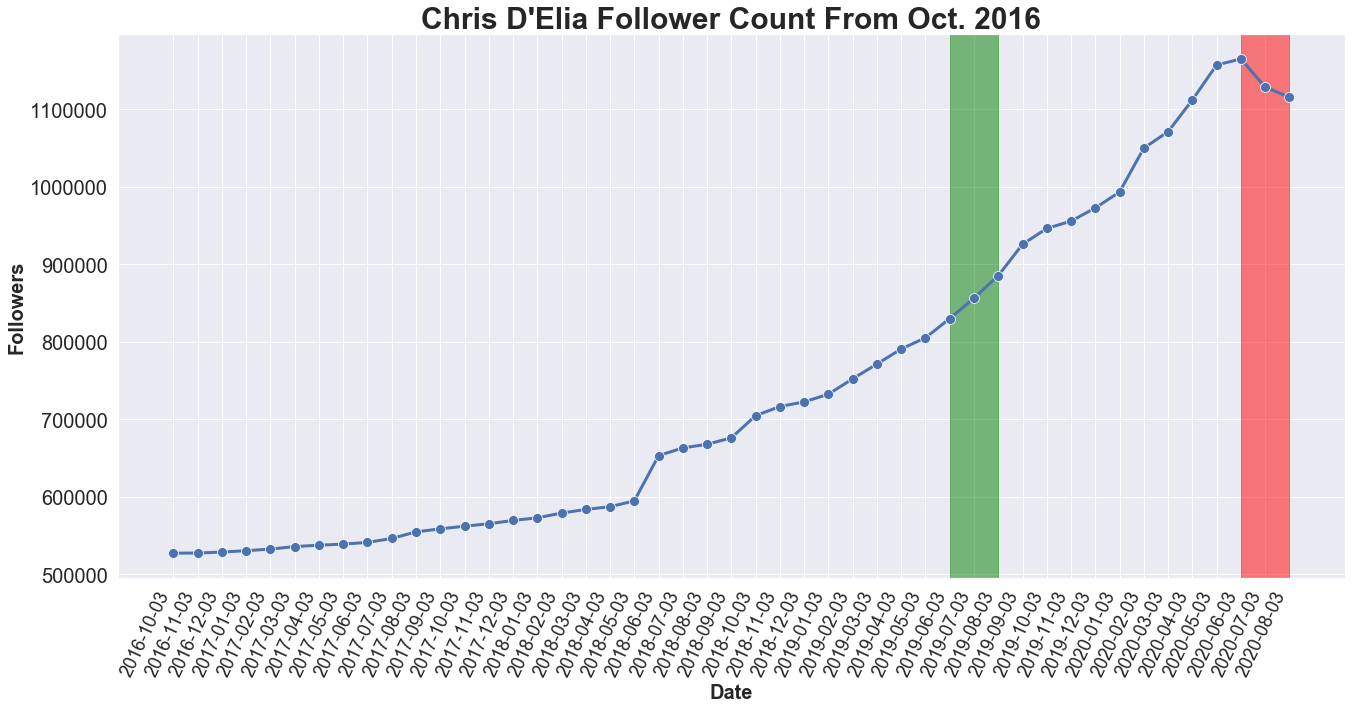

In [2]:
#Import chris's follower count since 2016
followers_2016 = pd.read_csv('Chris_Followers_From_2016.csv')


#Plot the historical follower count
plt.figure(figsize=(22,10))
sns.lineplot(x='Date', y='Followers', data=followers_2016, markers=True, linewidth=3, marker='o', markersize=10)
plt.title("Chris D'Elia Follower Count From Oct. 2016", size = 30, fontweight='bold')
plt.xlabel('Date', size=20, fontweight='bold')
plt.ylabel('Followers', size=20, fontweight='bold')
plt.xticks(rotation=65, size=18, horizontalalignment='right')
plt.yticks(size=20)
plt.axvspan(xmin=44, xmax=46, color='red', alpha=0.5)
plt.axvspan(xmin=32, xmax=34, color='green', alpha=0.5)
plt.show()

# 2.0 - Tweet Scraping - GetOldTweets3
Use the GetOldTweets3 API to extract tweets that mention Chris D'Elia. The following useful information about the tweets were also included.
* Date of tweet
* Username
* Num. of favorites
* Num. of retweets
* hashtags


In [3]:
#Make a function to extract tweets using GOT3
def download_tweets(StartDate, FinishDate, Query, num_tweets, wait_time):
    '''
    Downloads tweets within a certain time period and returns a dataframe of the tweets.
    Note: to avoid an error, approximately less than 10k tweets should be scraped every 10 minutes.
    
    Startdate and Finishdate should be strings. String of date, formatted: 'yyyy-mm-dd'. 
    Query = string of query Ex: "Chris D'Elia"
    num_tweets = integer value for number of tweets to be extracted per day
    wait_time = integer value for number of seconds to wait before extracting tweets for the next day
    '''
    #Convert the strings into datetime objects (for tracking time)
    start = datetime.strptime(StartDate, '%Y-%m-%d')
    finish = datetime.strptime(FinishDate, '%Y-%m-%d')
      
    #Create storage place for tweets - dataframe
    df = pd.DataFrame(columns=['date', 'username','tweet', 'favorites', 'retweets', 'hashtags'])
    
    while start < finish:       
        #Setup criteria for tweet extraction - 7500 tweets per day
        tweets_crit = got.manager.TweetCriteria().setQuerySearch(Query).setSince(start.strftime('%Y-%m-%d'))\
                                                 .setUntil((start + timedelta(days=1)).strftime('%Y-%m-%d'))\
                                                 .setMaxTweets(num_tweets)
        
        #Query/download the tweets
        daily_tweets = got.manager.TweetManager().getTweets(tweets_crit)
        
        #Extract the tweets and concatenate the tweets to the storage df
        tweets = [[tweet.date, tweet.username, tweet.text, tweet.favorites, tweet.retweets, tweet.hashtags] for \
                                                                                            tweet in daily_tweets]
        df_tweets = pd.DataFrame.from_records(tweets, columns=['date', 'username','tweet', 'favorites', 'retweets', 'hashtags'])
        df = pd.concat([df, df_tweets], axis = 0)
        
        #Puts program to sleep - prevents error of too many requests at one time
        time.sleep(wait_time)
        
        #Update StartDate
        start = start + timedelta(days=1)
    
    #Return the df of tweets
    return df

#Scrape the tweets from the two time periods being compared: Save a version of the raw data 
#tweets_2020 = download_tweets("2020-06-12","2020-07-27", "Chris DElia", 7500, 600)
#tweets_2020.to_csv('summer_2020_tweets.csv')
#tweets_2019 = download_tweets("2019-06-01","2019-08-01", "Chris DElia", 1000, 60)
#tweets_2019.to_csv('summer_2019_tweets.csv')

# 3.0 - Data Cleaning

### 3.1- Chris D'Elia Tweets 
The tweets extracted from the GetOldTweets3 library contain the following 6 fields. <br>
1) **date:** the date of the tweet (2020-06-06 23:56:08+00:00)<br>
2) **username:** the user that tweeted (Ex: savechrisdelia)<br>
3) **tweet:** the text of the tweet <br>
4) **favorites:** The number of favorites that tweet received.<br>
5) **retweets:** The number of retweets that tweet received. <br>
6) **hashtags:** The hashtags included with that tweet (Ex: #chrisdelia)


In [4]:
#Read in the tweets, reset index and drop entries where there is no tweet
tweets_2020 = pd.read_csv('summer_2020_tweets.csv', index_col='Unnamed: 0')
tweets_2019 = pd.read_csv('summer_2019_tweets.csv', index_col='Unnamed: 0')

#Cleans tweets that have not been categorized yet, fresh from download_tweets function
def clean_tweets(dataframe):
    """
    Input is a dataframe from the tweet scraping function, it returns a model-ready version of the data.
    """
    
    #Fill missing values for hashtags - replace null values with string 'None'
    dataframe['hashtags'].fillna('None', inplace = True)
    
    #Remove datapoints where there is a missing value for tweet - it will be useless for the sentiment anlaysis
    dataframe.dropna(inplace = True)
    
    #Convert datetime to string and extract the date in format (YYYY-MM-DD)
    dataframe['date'] = dataframe['date'].apply(lambda date: date.split(' ')[0])
    dataframe.reset_index(drop=True,inplace=True)
    
    return dataframe

#Use function on extracted tweets
tweets_2020 = clean_tweets(tweets_2020)
tweets_2019 = clean_tweets(tweets_2019)

tweets_2020.sample(3)   #Example of df

,date,username,tweet,favorites,retweets,hashtags
26543,2020-06-24,slopkinggg,@taftlax15,1.0,0.0,None
35465,2020-07-05,nadersquad11,That makes it okay then,0.0,0.0,None
14302,2020-06-18,mikewolfpack100,Are these guys kidding? Chris Delia ordering b...,26.0,18.0,None


### 3.2 - Sentiment140 Tweets
The dataset has the following 6 fields: <br>
1) **target:** the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)<br>
2) **ids:** The id of the tweet ( 2087)<br>
3) **date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009)<br>
4) **flag:** The query (lyx). If there is no query, then this value is NO_QUERY.<br>
5) **user:** the user that tweeted (robotickilldozr)<br>
6) **text:** the text of the tweet (Lyx is cool)

Recall that the reason this dataset is included is to train the model that will be used to determine the sentiment of Chris D'Elia tweets. Therefore, only the tweets and targets are needed as they are the only features/targets for training the model. Therefore the rest of the columns will be dropped, to save memory.

In [5]:
#Reading in sentiment140 tweets
sent140_filepath = 'Sentiment140.csv'
sent140_cols= ["target", "ids", "date", "flag", "user", "text"]
sent140_encoding = "ISO-8859-1"
sentiment140 = pd.read_csv(sent140_filepath, encoding=sent140_encoding, names=sent140_cols)

#Drop unneccessary data and convert labels into 'positive' or 'negative'
sentiment140.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
sentiment140['target'].replace({0:'negative',4:'positive'}, inplace=True)

# 4.0 - spaCy Modelling
Recall that the sentiment140 dataset is used to train/validate the spaCy model which will be used to predict the sentiment of tweets that mention Chris D'Elia. 

### 4.1 - spaCy Background
spaCy is a popular, free, open-source library for Natural Language Processing (NLP). A few of the many possible NLP tasks spaCy can be be used for: 
* Tokenization: Segments a text document into words (tokens)
* Lemmatization: Puts a word in its base form (Ex: running --> run)
* Part-of-speech (POS): Determines if the word is a pronoun, noun, verb, adverb, etc. 
* Sentence boundary detection (SBD): The model can detect when a sentence comes to an end.

At the center of spaCy models is the object which is usually called "nlp". The "nlp" object uses a pipeline which takes in a text document and processes it accordingly. Every "nlp" object can be used to load a premade model provided from spaCy or a blank model that can be used for your specific purpose. For example, there are premade models that are available from spaCy that come in different languages, that can be used for general-purpose or vocab, analyzes syntax and entities, trained on web text or news text, etc. These premade models can be trained with new data to make them perform better on a specific text type.

**Note**: Every spaCy processing pipeline has a tokenizer. It is possible to add more components to the pipeline such as a tagger, parser, entity recognizer, textcategorizer, etc.

For the purposes of the sentiment analysis, the pipeline will consist of a tokenizer and a TextCategorizer component to perform the classification. The default model algorithm in the TextCategorizer is a stacked ensemble of a bag-of-words model and a neural network model that uses a CNN with mean pooling and attention.


### 4.2 - Defining the Model
In this notebook, I use a blank spaCy model because we are analyzing tweets. This means that the spaCy model has to be trained specifically on text from tweets. Other text such as news articles or blogs have a very different syntax than tweets and therefore the model would not perform well. As mentioned above, the pipeline in the "nlp" object will consist of a tokenizer and a TextCategorizer object that will classify negative/positive tweets.

**TIP:** It is a HUGE time saver to train the model using a bag-of-words architecture instead of the standard ensemble - this will likely yield lower accuracy. The model type can be changed in the config. arguement when creating the TextCategorizer pipe.

In [7]:
#Create blank spacy model that will be trained on sentiment140 data
nlp = spacy.blank('en')

#Create pipeline in spaCy (spaCy pipes) to create preprocessing/transforming object for tokens
text_cat = nlp.create_pipe("textcat", config={"exclusive_classes":True})

#Add the pipeline to the spacy model
nlp.add_pipe(text_cat)

#Add labels (target categories) to the classifier
text_cat.add_label('negative')
text_cat.add_label('positive')

1

### 4.3 - Training the TextCategorizer
The next step is to train the nlp TextCategorizer, but first split the data into training/validation sets and randomly shuffle the data. <br>

In [7]:
#Define inputs and targets
inputs = sentiment140['text']
targets = sentiment140['target']

#split the training set into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.20, random_state=42)
print(X_train.shape, X_val.shape)

#Convert dataframes into numpy arrays - used for training/predictions
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values

(1280000,) (320000,)


**Summary of what model does:** <br>
First, it initialize the weights randomly, this is done using the method .begin_training(). Next, we batch the samples and call nlp.update() which creates predictions for that batch and compares them against their respective labels. Loss values are calculated and these are used to update the current weights, this process repeats for all the batches until the epoch is complete. This is done continuously for the defined number of epochs and can be a timely process so be careful with the hyperparameters used.

**TIP:** Larger batches make for quicker processing times but are less accurate. Smaller batches are more accurate but dramatically increase processing time.

**NOTE:** To use the TextCategorizer later, the nlp object must be trained on data that has a specific format. It requires a dictionary of boolean values for each class. The model looks for this dictionary in another dictionary with the key 'cats'.<br>
Finally, zip the tweets and labels (negative/positive) used for training together to produce a list of [(tweet, label), (tweet, label), ...] tuples.

In [8]:
#Import library/objects used for making the function
import random
from spacy.util import minibatch

#Making a function to train the model. 
#Arguments will be: x_train, y_train, optimizer, number of epochs
def train(x_train, y_train, optimizer, num_epochs):
    """
    Function to train the spaCy model, takes four arguements defined in the following manner.
    
    x_train = numpy array of texts/documents
    y_train = numpy array of labels (positive/negative) for corresponding texts/documents
    optimizer = spaCy object used to initialize weights for the CNN.
    num_epochs = Integer defining number of epochs used to train the model.
    """
    #Define the random seed so the results are reproducable
    random.seed(42)
    spacy.util.fix_random_seed(42)
    
    #Setup training data for nlp.update(). Each label is a dictionary as described above.
    train_labels = [{'cats':{'negative':label=='negative', 'positive':label=='positive'}} for label in y_train]
    train_data = list(zip(x_train, train_labels))
    
    #Define a dictionary to store losses for each epoch
    losses={}
    for epoch in range(num_epochs):     
        #Create batch generator 
        batches = minibatch(train_data, size=1024)

        #Iterate through minibatches
        for batch in batches:
            #Each batch is a list of (text, label) tuples.
            #But we need to send separate lists for texts and labels to update().
            texts, labels = zip(*batch)
            nlp.update(texts, labels, drop=0.1, sgd=optimizer, losses=losses)
        print(losses)

#Defining arguments to enter into the function
optimizer = nlp.begin_training() #Initialize the model weights randomly
epochs = 10

#Call the function with the defined parameters to train the nlp model
#train(X_train, y_train, optimizer, epochs)

In [9]:
#Optional: save the model

#Use the open() function to open a file. Set the file mode to 'wb' to open the file for writing in binary mode. 
#Wrap it in a with statement to ensure the file is closed automatically when you’re done with it.
#The dump() function in the pickle module takes a serializable Python data structure, serializes it into a binary, 
#Python-specific format using the latest version of the pickle protocol, and saves it to an open file.


#with open('spaCy_sent140_model_v3', 'wb') as file:
    #pickle.dump(nlp, file)

### 4.4 - Validating the TextCategorizer
To make predictions using the TextCategorizer object the documents/tweets can simply be entered as a numpy array. After the predictions are made the model can be assessed using a number of metrics. The classification report is a general summary that provides information on metrics like accuracy, recall, sensitivity etc.

In [9]:
#Loading in the model

#The pickle module uses a binary data format,so you should always open pickle files in binary mode.
#The pickle.load() function takes a stream object, reads the serialized data from the stream, 
#creates a new Python object, recreates the serialized data in the new Python object, and returns the new Python object.
with open('spaCy_sent140_model_v2', 'rb') as file:
    nlp = pickle.load(file)
    

In [10]:
#Make a function to predict sentiment
import random
def sentiment_predict(pred_data, sample=False):  
    """
    Function used to predict sentiment of text documents, returns a pandas dataframe of predictions.
        
    pred_data = A pandas series/dataframe or numpy array of texts/documents
    sample: Boolean value that will return an example of the sentiment prediction for a randomly chosen tweet when True.
            It returns the tweet, probabilities for a 'negative' label and 'positive' label and the choosen label.
    """  
    #Tokenize the documents/tweets
    tokenized_data = [nlp.tokenizer(tweet) for tweet in pred_data]
    
    #Use the textcategorizer object from the trained model to make predictions
    textcat = nlp.get_pipe('textcat')
    
    #Use textcat to get the score for each tweet's label
    scores,_ = textcat.predict(tokenized_data)
    
    #Get model predictions from the score
    predicted_labels = scores.argmax(axis=1)
    
    #Pick a random tweet from the df
    number = random.randrange(1,pred_data.shape[0])
    
    #Show an example of what the score looks like for each label
    if sample == True:
        print(f'Random tweet:  \n{pred_data[number]}\n')
        print('Example of scores for the random tweet:\nnegative    positive')
        print(scores[number])
        print('The tweets label is: ', textcat.labels[predicted_labels[number]])
    
    #Convert the predicted labels from integers to negative and positive labelsto match the format of the validation labels
    predicted_labels = pd.DataFrame(predicted_labels)
    predicted_labels.replace({0:'negative', 1:'positive'}, inplace=True)
    
    #return the predicted labels to assess the models performance
    return predicted_labels

In [12]:
#Make predictions for the sentiment140 validation set
val_preds = sentiment_predict(X_val, sample=True)

#Compare validation predictions to the labels
print('\n', confusion_matrix(val_preds,y_val))
print(classification_report(val_preds,y_val))

Random tweet:  
@devbanana nice! no idea about C++. try IBM's TTS works great IMO. 

Example of scores for the random tweet:
negative    positive
[0.01077358 0.9892264 ]
The tweets label is:  positive

 [[133444  23485]
 [ 26050 137021]]
              precision    recall  f1-score   support

    negative       0.84      0.85      0.84    156929
    positive       0.85      0.84      0.85    163071

    accuracy                           0.85    320000
   macro avg       0.85      0.85      0.85    320000
weighted avg       0.85      0.85      0.85    320000



The spaCy TextCategorizer has performed reasonably well on the sentiment140 validation set - a score of 85% in the majority of classification metrics. Now that it has been trained to analyze tweets, it can be used to predict the sentiment of tweets that mention Chris D'Elia.

# 5.0 - Sentiment Analysis
The next step is to use the spaCy model we created to predict the sentiment of tweets that mention Chris from 2019 and 2020.

In [11]:
#Predict the sentiment of the tweets mentioning Chris D'Elia
tweets_2020['Sentiment'] = sentiment_predict(tweets_2020['tweet'])
tweets_2019['Sentiment'] = sentiment_predict(tweets_2019['tweet'])

#Save the results
#tweets_2020.to_csv('2020_sentiment.csv')
#tweets_2019.to_csv('2019_sentiment.csv')

#Example
tweets_2020[['Sentiment', 'tweet']].sample(10)

,Sentiment,tweet
34118,positive,Haha the best!
3245,positive,Yoooo RELAX !!!!
28460,positive,That’s some straight up ass cuda shit. Definit...
37718,positive,@chrisdelia think about ya everyday bro #TheGe...
10199,negative,@chrisdelia another s-pawn taken off the chess...
17366,positive,You're just being fucking sloppy now goofball
19664,positive,Okay I’m glad you’re having a laugh now I was ...
32161,positive,"just rewatched Incorrigible, had me laughing t..."
31086,negative,Read the articles released there's no crime.
29874,positive,I’ll go back to school once you acknowledge th...


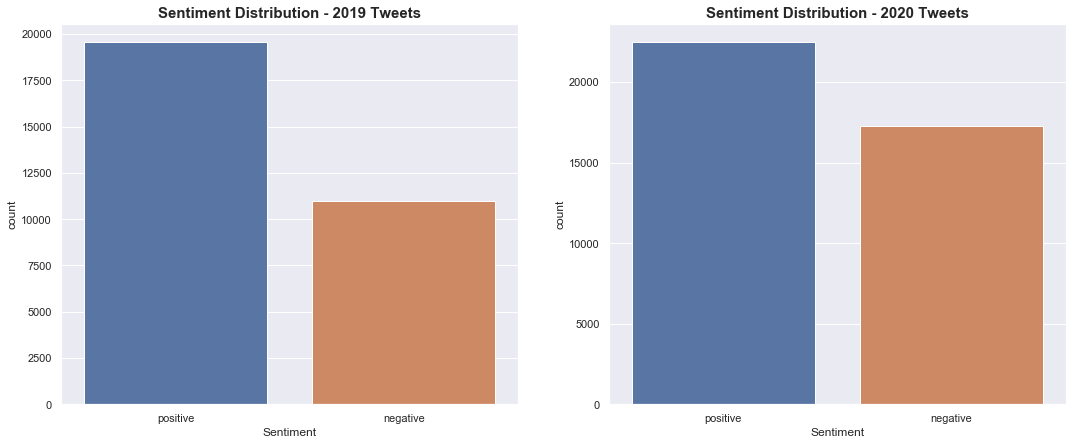

Ratio of negative:positive tweets for Summer 2019 
1.0 : 1.78

Ratio of negative:positive tweets for Summer 2020 
1 : 1.3


In [12]:
#Create the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

#Plot the sentiment distribution for 2019 tweets
sns.countplot(tweets_2019['Sentiment'], ax=axes[0], order=['positive','negative'])
axes[0].set_title('Sentiment Distribution - 2019 Tweets', size=15, fontweight='bold')

#Plot the sentiment distribution for 2020 tweets
sns.countplot(tweets_2020['Sentiment'], ax=axes[1], order=['positive','negative'])
axes[1].set_title('Sentiment Distribution - 2020 Tweets', size=15, fontweight='bold')
plt.show()

#Positive tweets
pos_2019 = tweets_2019[tweets_2019['Sentiment']=='positive']['Sentiment'].count()
pos_2020 = tweets_2020[tweets_2020['Sentiment']=='positive']['Sentiment'].count()

#Negative tweets
neg_2019 = tweets_2019[tweets_2019['Sentiment']=='negative']['Sentiment'].count()
neg_2020 = tweets_2020[tweets_2020['Sentiment']=='negative']['Sentiment'].count()

#Print the ratio of negative to positive tweets
print(f'Ratio of negative:positive tweets for Summer 2019 \n{neg_2019/neg_2019} : {(pos_2019/neg_2019).round(2)}')
print(f'\nRatio of negative:positive tweets for Summer 2020 \n1 : {(pos_2020/neg_2020).round(2)}')

**Observations** 
* In both 2019 and 2020, there were more positive tweets than negative tweets.
* In 2020 there was a signigicant increase in the number of negatively classified tweets with respect to the number of positiely classified tweets. 

**Conclusions** <br>
All publicity is not good publicity. After his controversy, the overall public opinion of Chris has become more negative. This is likely the cause of his follower loss, perhaps "casual fans" who saw this controversy unravel are the main reason behind his follower loss. This brings up an interesting situation, if I had access to who follows him I could run a clustering algorithm based on the number of interactions and if the person followed/unfollowed him. With this I could determine if there are specific groups that are more likely to follow/unfollow him. (Ex: "Casual fans" may tweet about him once or twice and unfollow). After gaining a understanding of his follwer base, a PR strategy could be implemented to change his overall image.